# Прогнозирование оттока клиентов для фитнес-центра

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что пользователь больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

### Навигация

1. [Загрузка данных](#start)
2. [Исследовательский анализ данных (EDA)](#discover)
3. [Построение модели прогнозирования оттока пользователей](#model)
4. [Кластеризация пользователей.](#claster) 
5. [Общий вывод.](#Conclusio)


### <a id="start"></a> Шаг 1. Загрузка данных

In [56]:
# импорт необходимых библиотек

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [57]:
# сохраним датафрейм в переменную fd (fitness data)
fd = pd.read_csv('/datasets/gym_churn.csv')
fd.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [58]:
# проверим датафрейм на наличие пропусков и верный тип данных
fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


#### Датафрейм состоит из 14 столбцов и 4000 наблюдений (строк).

Целевая переменная - 'Churn'  — факт оттока в текущем месяце.
Все переменные - числовые, категориальных нет.

Текущие поля (признаки ) в датасете:

- Данные пользователя за предыдущий до проверки факта оттока месяц:


1. 'gender' — пол (1 - женщина, 0 - мужчина)
2. 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
3. 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
4. Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
5. 'Phone' — наличие контактного телефона
6. 'Age' — возраст
7. 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).



- Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:


8. 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
9. 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
10. 'Group_visits' — факт посещения групповых занятий
11. 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
12. 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
13. 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

### Шаг 2. <a id="discover"></a> Исследовательский анализ данных (EDA)

#### Посмотрите на датасет: есть ли в нем отсутствующие признаки, изучите средние значения и стандартные отклонения

In [59]:
fd.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


По первой оценке признаков можно сделать несколько основных выводов о портрете среднего клиента компании:
1. клиентом является женщина (1)
2. проживание или работа в районе, где находится фитнес-центр
3. не работает у партнера финтес центра
4. не имеет отношения к акции "приведи друга"
5. имеет контактный телефон
6. абонемент на 4-6 месяцев
7. не ходит на групповые занятия
8. возраст 29 лет (самому взрослому клиенту компании 41 год)
9.  суммарная выручка от других услуг фитнес-центра в диапазоне 140-210.
10. до окончания абонемента 4-6 месяцев (совпадает с длительностью самого абонемента)
11. лайфтайм составляет около 3-4 мес.
12. ходит 1-2 раза в неделю

#### Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался


In [60]:
fd.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Исходя из средних значений в разрезе тех, кто ушел и остался, можно сделать первые предположения о портрете "ушедшего" клиента:
1. пол, место расположения фитнес зала, возраст и траты на дополнительные услуги не имеют значения.
2. участие в программе "приведи друга", работа в компании-парнере, участие в групповых занятих и срок абонемента (чем длинее) повышают вероятность остаться в фитнес центре.

#### Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался.

gender


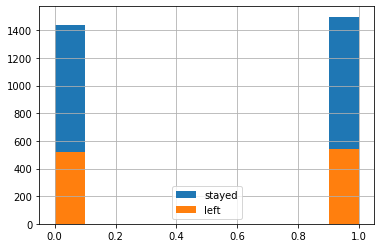

Near_Location


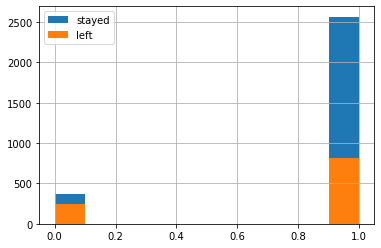

Partner


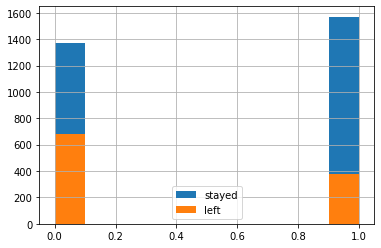

Promo_friends


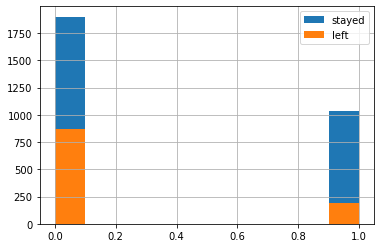

Phone


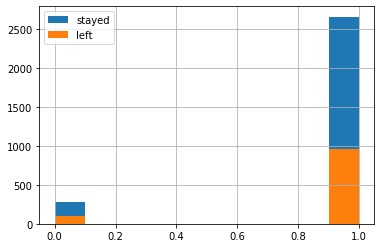

Contract_period


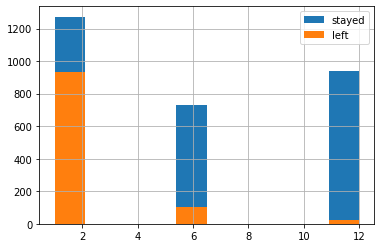

Group_visits


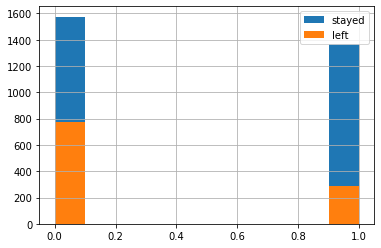

Age


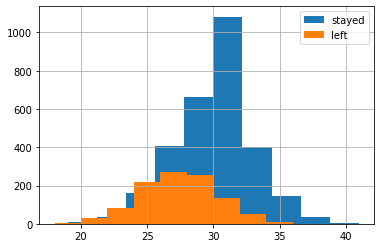

Avg_additional_charges_total


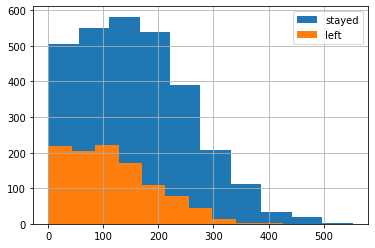

Month_to_end_contract


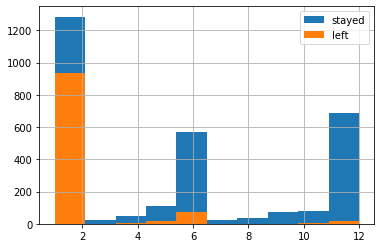

Lifetime


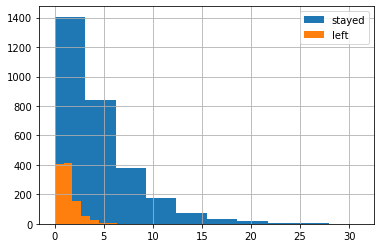

Avg_class_frequency_total


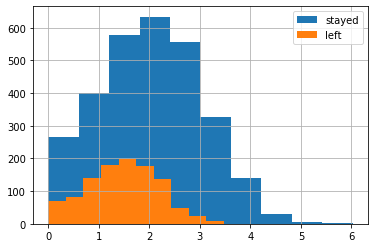

Avg_class_frequency_current_month


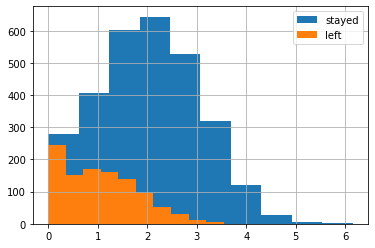

Churn


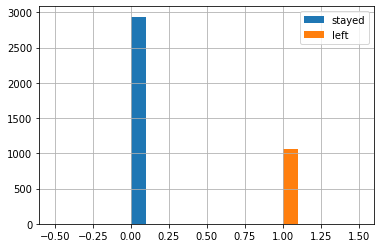

In [61]:
fd_left = fd.query('Churn == 1')
fd_stayed = fd.query('Churn == 0')
 
for i in fd.columns:
    print(i)
    fd_stayed[i].hist(label = 'stayed')
    fd_left[i].hist(label = 'left')
    plt.legend()
    plt.show()

Исходя из гистограмм можно сделать вывод, что:
1. среди ушедших в равной доле и мужчин и женщин (примерно по 500)
2. те, кто приходят в рамках акции приведи друга или работают в компании партнере, уходят в меньшем числе случаев
3. кто покупает абонемент на 1 месяц с большей вероятностью перестанет посещать фитнес-центр
4. посещение групповых занятий снижает вероятность уйти
5. дополнительные расходы тех, кто остался выше, чем у тех, кто ушел
6. за прошлый месяц ушло примерно 1000 человек.

#### Постройте матрицу корреляций и отобразите её.


In [62]:
# построим матрицу корреляции
corr = fd.corr()
corr

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
Near_Location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
Partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
Promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
Phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
Contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
Group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
Age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
Avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
Month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


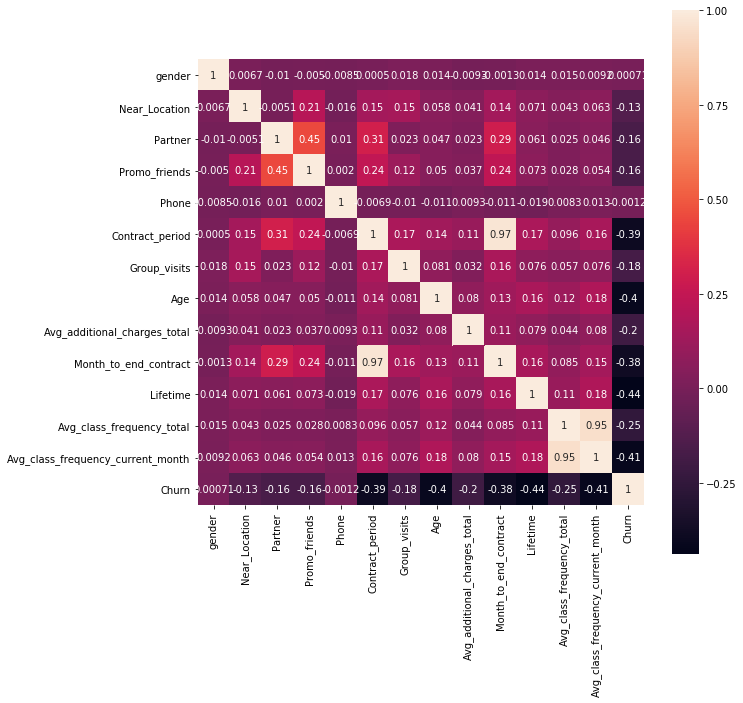

In [63]:
# визуализируем матрицу
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot = True, square=True)

Исходя из матрицу можно сделать предварительный вывод, что положительная зависимость есть между участием в акции "приведи друга" и работой клиента в компании партнере, а также между клиентом партнера и периодом до окончания абонемента.

Положительная зависимость между средней частотой посещений в неделю за все время с начала действия абонемента и средней частотой посещений в неделю за предыдущий месяц (коэффициент 0,95).

Высокая корреляция между сроком абонемента и сроком до окончания текущего действующего абонемента.

Отрицательная корреляция наблюдается между фактом оттока клиента и различными параметрами.

## Шаг 3. <a id="model"></a> Построение модели прогнозирования оттока пользователей


#### Логистическая регрессия


In [64]:
# разделите наши данные на признаки (матрица X) и целевую переменную (y)
X = fd.drop('Churn', axis = 1)
y = fd['Churn']

# разделите модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# стандартизируем данные 
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [65]:
# алгоритм для модели линейной регрессии
model = LogisticRegression()

# обучение модели
model.fit(X_train_st, y_train)

# прогнозы
predictions = model.predict(X_test_st)
probabilities = model.predict_proba(X_test_st)[:,1]

print('Метрика Accuracy для линейной модели: {:.2f}'.format(accuracy_score (y_test, predictions)))
print('Метрика Precision для линейной модели: {:.2f}'.format(precision_score (y_test, predictions)))
print('Метрика Recall для линейной модели: {:.2f}'.format(recall_score (y_test, predictions)))

Метрика Accuracy для линейной модели: 0.92
Метрика Precision для линейной модели: 0.85
Метрика Recall для линейной модели: 0.83


In [66]:
# алгоритм для модели случайного леса

rf_model = RandomForestClassifier(n_estimators = 100)
rf_model.fit(X_train_st, y_train)
y_pred = rf_model.predict(X_test_st)
y_prob = rf_model.predict_proba(X_test_st)[:,1]

print('Метрика Accuracy для случайного леса: {:.2f}'.format(accuracy_score (y_test, y_pred)))
print('Метрика Precision для случайного леса: {:.2f}'.format(precision_score (y_test, y_pred)))
print('Метрика Recall для случайного леса: {:.2f}'.format(recall_score (y_test, y_pred)))

Метрика Accuracy для случайного леса: 0.92
Метрика Precision для случайного леса: 0.85
Метрика Recall для случайного леса: 0.83


#### Исходя из полученных результатов следует, что обе модели (линейная регрессия и случайный лес) показывают хорошие результаты, у линейной регрессии даже немного лучше. 

Однако поскольку число ушедших в 3 раза меньше, чем тех, кто остался, то целесообразно откорректировать прогноз с учетом несбалансированности выборки.

In [67]:
# задаем порог
threshold = 0.4 

# на основании вероятностей и соотношения классов рассчитаем predict для линейной регрессии
custom_predictions = [0 if i <threshold else 1 for i in probabilities]

In [68]:
print('Метрики для прогноза с кастомным порогом')
print('Метрика Accuracy для линейной модели: {:.2f}'.format(accuracy_score(y_test, custom_predictions)))
print('Метрика Precision для линейной модели: {:.2f}'.format(precision_score(y_test, custom_predictions)))
print('Метрика Recall для линейной модели: {:.2f}'.format(recall_score(y_test, custom_predictions)))

Метрики для прогноза с кастомным порогом
Метрика Accuracy для линейной модели: 0.92
Метрика Precision для линейной модели: 0.82
Метрика Recall для линейной модели: 0.86


In [69]:
# задаем порог
threshold = 0.4 

# на основании вероятностей и соотношения классов рассчитаем predict для случайного леса
custom_predictions_forest = [0 if i <threshold else 1 for i in y_prob]

In [70]:
print('Метрики для прогноза с кастомным порогом')
print('Метрика Accuracy для случайного леса: {:.2f}'.format(accuracy_score (y_test, custom_predictions_forest)))
print('Метрика Precision для случайного леса: {:.2f}'.format(precision_score (y_test, custom_predictions_forest)))
print('Метрика Recall для случайного леса: {:.2f}'.format(recall_score (y_test, custom_predictions_forest)))

Метрики для прогноза с кастомным порогом
Метрика Accuracy для случайного леса: 0.92
Метрика Precision для случайного леса: 0.80
Метрика Recall для случайного леса: 0.90


###### Очевидно, что изменение порога разительно не повлияло на результаты, обе модели показывают хорошие результаты.

## Шаг 4.  <a id="claster"></a> Кластеризация пользователей.

In [71]:
# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = scaler.fit_transform(fd.drop(columns = ['Churn']))

linked = linkage(X_sc, method = 'ward')

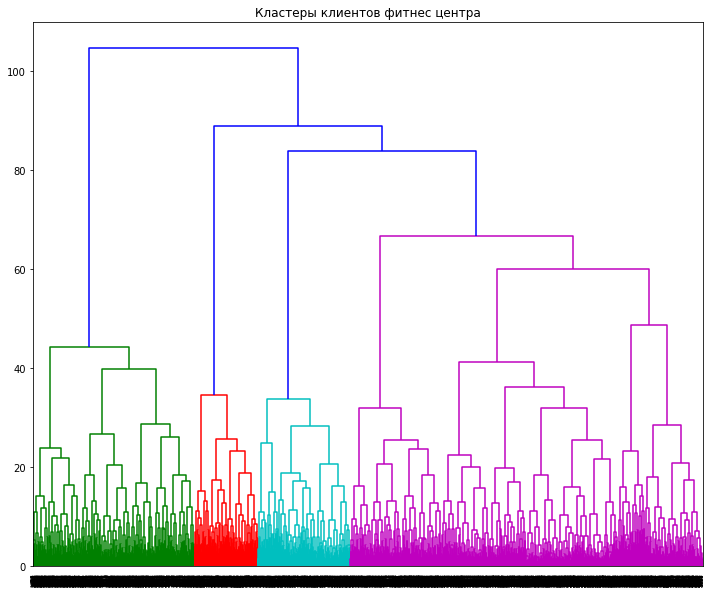

In [72]:
# построение дендрограммы

plt.figure(figsize=(12, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеры клиентов фитнес центра')
plt.show()

###### Из полученного графика можно выделить несколько кластеров пользователей. Все зависит от того - как провести линию, и определить пересекаемые вертикальные линии. Если смотреть по выделенным цветам, то видится логичным выделить 4 кластера. 

In [73]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5)

# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

In [74]:
# сохраняем метки кластера в поле нашего датасета
fd['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
fd.drop('Churn', axis = 1).groupby('cluster_km').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
cluster_km,,,,,,,,,,,,,
0,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324
1,0.557920,0.976359,0.359338,0.235225,0.998818,2.689125,0.469267,30.109929,161.895609,2.479905,4.875887,2.849407,2.847981
2,0.486122,1.000000,0.351308,0.239492,1.000000,1.953212,0.341792,28.168914,131.337907,1.861221,2.443299,1.246756,1.011916
3,0.503490,0.959123,0.782652,0.573280,1.000000,10.923230,0.546361,29.991027,160.881742,9.983051,4.748754,1.977676,1.970029
4,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369


gender


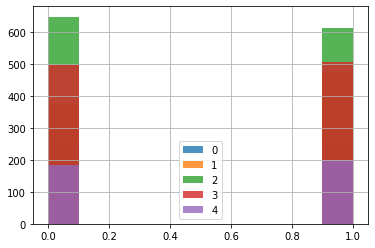

Near_Location


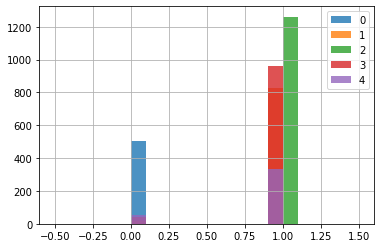

Partner


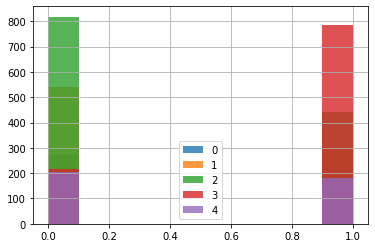

Promo_friends


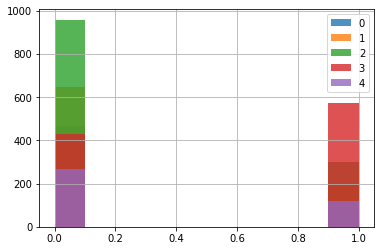

Phone


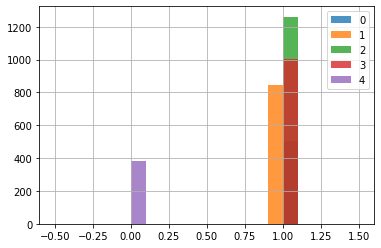

Contract_period


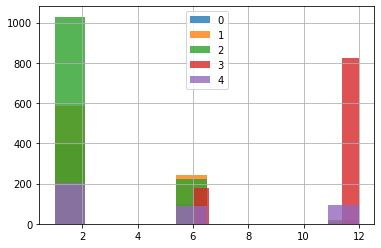

Group_visits


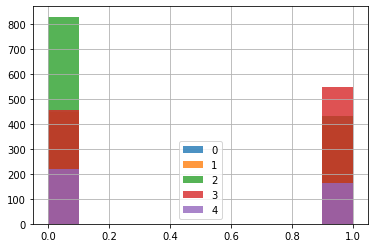

Age


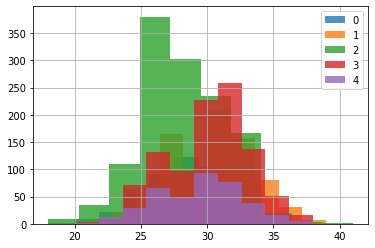

Avg_additional_charges_total


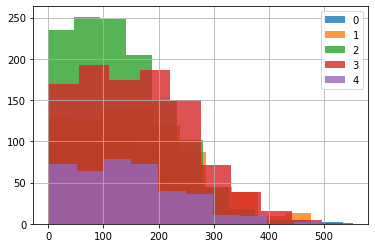

Month_to_end_contract


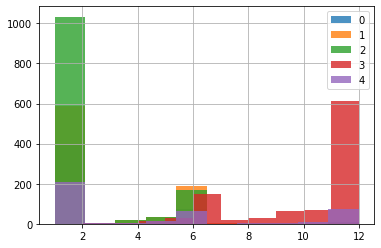

Lifetime


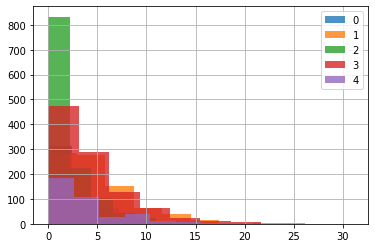

Avg_class_frequency_total


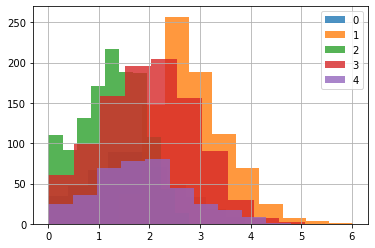

Avg_class_frequency_current_month


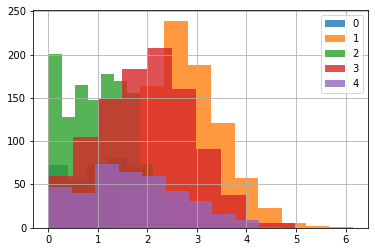

Churn


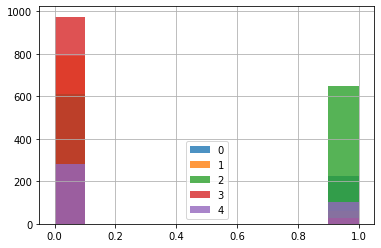

cluster_km


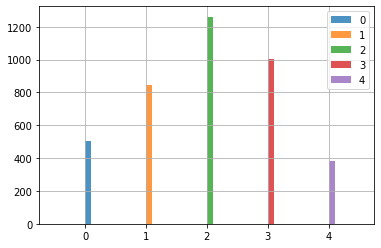

In [75]:
fd_0 = fd.query('cluster_km == 0')
fd_1 = fd.query('cluster_km == 1')
fd_2 = fd.query('cluster_km == 2')
fd_3 = fd.query('cluster_km == 3')
fd_4 = fd.query('cluster_km == 4')

for i in fd.columns:
    print(i)
    fd_0[i].hist(label = '0', alpha=0.8)
    fd_1[i].hist(label = '1', alpha=0.8)
    fd_2[i].hist(label = '2', alpha=0.8)
    fd_3[i].hist(label = '3', alpha=0.8)
    fd_4[i].hist(label = '4', alpha=0.8)    
    
    plt.legend()
    plt.show()

##### Выводы 
Исходя из среза по средним значения параметров для полученных кластеров можно сделать предварительные выводы:
1. в 3 группах преобладают женщины
2. в 4 кластерах посетители живут или работают рядом с фитнес центром
3. в промо акции "приведи друга" участвуют и в компании партнере работают клиенты только одного кластера - они покупают и самый продолжительный абонемент (почти на 11 мес.), они же и завсегдатаи групповых занятий
4. больше всего дополнительного достатка приносят кластеры 1 и 3.
5. больше всего занятий в неделю совершают клиенты 3 кластера, у них же и лучший показатель времени с момента первого обращения в фитнес-центр

In [76]:
# посмотри долю оттока для каждого кластера
fd.groupby('cluster_km')['Churn'].mean()

cluster_km
0    0.443564
1    0.068558
2    0.513878
3    0.027916
4    0.267532
Name: Churn, dtype: float64

######  Вывод
Очевидно, что процент ушедших для кластеров отличается.

Самые лучшие результаты показывает кластер №1, из которого ушло менее 3% клиентов. Причины такой стабильности можно найти в предыдущем пункте - клиенты этой группы самые лояльные к компании в связи с участием в акции "приведи друга", работе в компании-партнере и активным занятиям в группах.

Наивысший процент ушедших во кластере №2 - они не участвовали в промо, среди них много мужчин, они редко посещают групповые занятия и мало тратят денег на дополнительные услуги, при этом они покупают самые короткие абонементы (до 2 мес.).

## Шаг 5. <a id="Conclusio"></a> Общие выводы

#### Датафрейм состоит из 14 столбцов и 4000 наблюдений (строк).

Целевая переменная - 'Churn'  — факт оттока в текущем месяце.

По первой оценке признаков, сформирован портрет среднего клиента компании:
1. это женщина (1)
2. проживает или работа в районе, где находится фитнес-центр
3. не работает у партнера финтес центра
4. не имеет отношения к акции "приведи друга"
5. имеет контактный телефон
6. абонемент покупает на 4-6 месяцев
7. не ходит на групповые занятия
8. возраст 29 лет (самому взрослому клиенту компании 41 год)
9.  суммарная выручка от других услуг фитнес-центра в диапазоне 140-210.
10. ходит в зал 1-2 раза в неделю

Построив дендрограммы, выделили 5 кластеров.
По результатам оценки их особенностей, можно дать следующие рекомендации по сохранению и привлечению лояльных клиентов:
1.	Активное вовлечение в акцию «приведи друга», развитие работы с компаниями-партнерами – такие клиенты охотнее продолжают занятия даже спустя время. Можно предложить действующим клиентам дополнительные льготы и бонусы за привлечение их друзей и родных в наш фитнес зал.
2.	Необходимо приучать клиентов посещать групповые занятия – это способствует сближению клиентов, развитию дружеских/романтических отношений на фоне общих интересов. Можно дарить клиентам на праздники бесплатные занятия или делать акционные предложения для посещения групповых занятий.
3.	В рекламной компании лучше ориентироваться на женскую половину – они стабильнее посещает занятий, их отток меньше. Возраст потенциальных клиентов – до 30 лет. 
4.	Лучше ориентироваться на заключение долгосрочных абонементов – такие клиенты заинтересованнее посещают занятия и ответственнее относятся к тренировках. Можно предложить выгодные цены для друзей клиентов, например, так совместится сразу два направлению по совершенствованию политики компании в части удержания клиентов.
